In [1]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

# Find data

# Test file.wav

In [2]:
import wave
import numpy as np
import matplotlib.pyplot as plt

Channels: 1
Sample Width: 2
Frame Rate (Sample Rate): 16000
Number of Frames: 48000


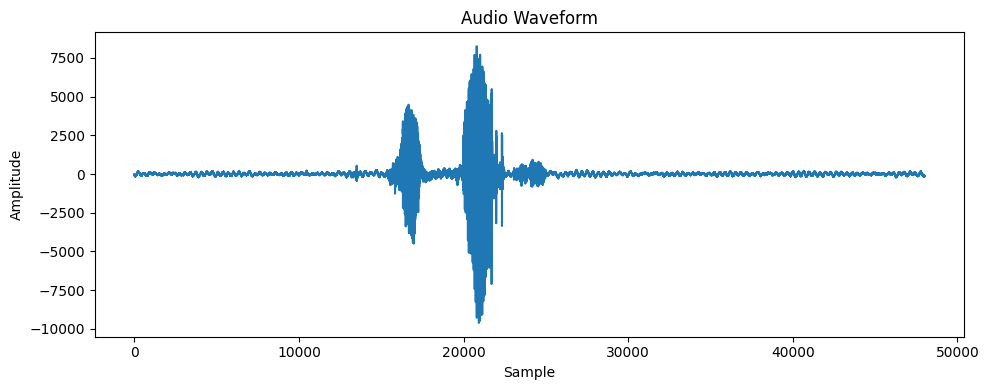

In [3]:
# Load the WAV file
with wave.open('/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves/VIVOSSPK01/VIVOSSPK01_R001.wav', 'rb') as wav_file:
    n_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    frame_rate = wav_file.getframerate()
    n_frames = wav_file.getnframes()

    print(f"Channels: {n_channels}")
    print(f"Sample Width: {sample_width}")
    print(f"Frame Rate (Sample Rate): {frame_rate}")
    print(f"Number of Frames: {n_frames}")

    # Read the raw audio frames
    audio_frames = wav_file.readframes(n_frames)

# Convert byte data to numpy array
audio_data = np.frombuffer(audio_frames, dtype=np.int16)

# If stereo, reshape for 2 channels
if n_channels == 2:
    audio_data = audio_data.reshape(-1, 2)

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_data)
plt.title("Audio Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


## log-Mel spectrogram

Transformer input shape: (155, 80)
[[-37.19281  -41.452507 -54.800446 ... -76.59099  -80.       -80.      ]
 [-32.874374 -35.794342 -46.502632 ... -76.43584  -80.       -80.      ]
 [-31.877998 -33.37876  -40.44529  ... -75.99472  -77.026505 -79.84212 ]
 ...
 [-35.90571  -44.249912 -46.34314  ... -80.       -80.       -80.      ]
 [-33.619766 -36.990837 -47.962524 ... -77.98218  -79.6029   -80.      ]
 [-34.070686 -40.613266 -48.65172  ... -77.67384  -80.       -80.      ]]


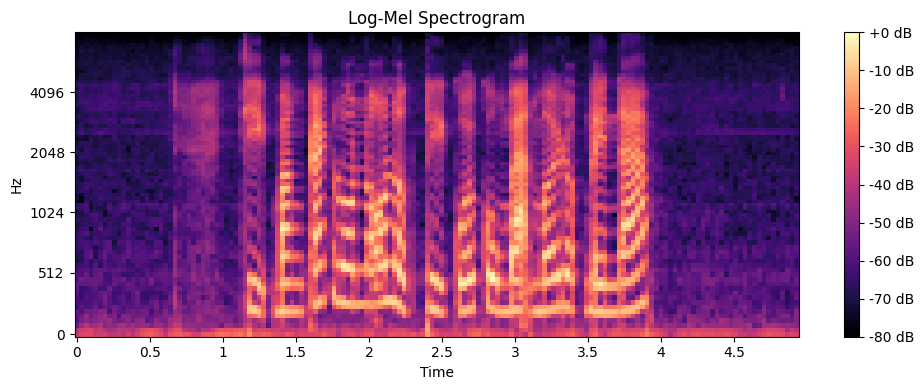

In [4]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Load and convert to mono
y, sr = librosa.load("/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves/VIVOSSPK01/VIVOSSPK01_R002.wav", sr=None)

# Normalize audio
y = y / np.max(np.abs(y))

# Extract log-Mel spectrogram (good input for Transformer models)
n_mels = 80
n_fft = 1024
hop_length = 512

mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                                 hop_length=hop_length, n_mels=n_mels)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Shape it to (Time, Features)
features = log_mel_spectrogram.T
print("Transformer input shape:", features.shape)  # e.g., (time_steps, 80)
print(features)

# Visualize
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


## Torchaudio

In [5]:
import torch
import torchaudio
import matplotlib.pyplot as plt

Waveform shape: torch.Size([1, 79000]), Sample rate: 16000
Transformer input shape: torch.Size([155, 80])


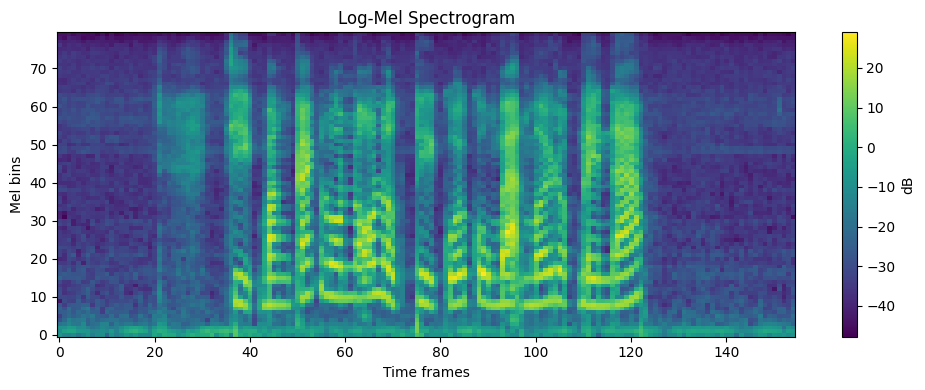

In [6]:

# Load the WAV file using torchaudio
waveform, sample_rate = torchaudio.load("/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves/VIVOSSPK01/VIVOSSPK01_R002.wav")
print(f"Waveform shape: {waveform.shape}, Sample rate: {sample_rate}")

# Convert to mono if stereo
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Apply transformation to extract log-Mel spectrogram
transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=512,
    n_mels=80
)

mel_spec = transform(waveform)
log_mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)

# Shape to (time_steps, mel_features) for transformer
features = log_mel_spec.squeeze(0).T
print(f"Transformer input shape: {features.shape}")

# Plot the log-Mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spec.squeeze().numpy(), aspect='auto', origin='lower')
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()


## MFCC


MFCCs shape: (13, 213)
Sample Rate: 22050


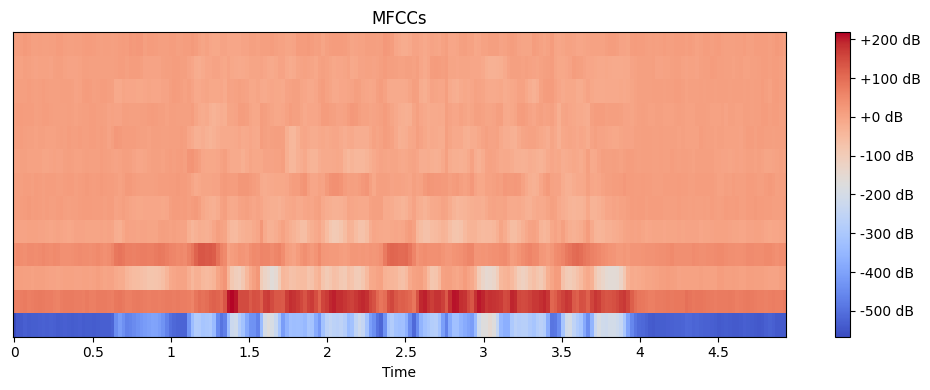

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def process_wav_to_mfcc(file_path, n_mfcc=13, hop_length=512, n_fft=2048):
    """
    Processes a .wav file to extract Mel-Frequency Cepstral Coefficients (MFCCs).

    Args:
        file_path (str): The path to the .wav audio file.
        n_mfcc (int): The number of MFCCs to return. Common values are 12 or 13.
        hop_length (int): The number of samples between successive frames.
                          A smaller hop_length means more frames and finer temporal resolution.
        n_fft (int): The number of FFT components. This determines the window size.

    Returns:
        numpy.ndarray: A 2D array of MFCCs, where rows are MFCC coefficients
                       and columns are frames.
        int: The sampling rate (sr) of the audio file.
    """
    try:
        # Load the audio file
        y, sr = librosa.load(file_path)

        # Extract MFCCs
        # librosa.feature.mfcc computes the MFCCs from a time series
        # By default, it computes 20 MFCCs from a short-time Fourier transform (STFT)
        # of the input signal.
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

        return mfccs, sr

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

def plot_mfccs(mfccs, sr, title="MFCCs", hop_length=512):
    """
    Plots the Mel-Frequency Cepstral Coefficients (MFCCs).

    Args:
        mfccs (numpy.ndarray): The 2D array of MFCCs.
        sr (int): The sampling rate of the audio file.
        title (str): Title for the plot.
        hop_length (int): The hop length used when extracting MFCCs (for accurate time axis).
    """
    if mfccs is not None:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=hop_length)
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    try:
        from scipy.io.wavfile import write
        import numpy as np

        mfccs_result, sample_rate = process_wav_to_mfcc("/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves/VIVOSSPK01/VIVOSSPK01_R002.wav")

        if mfccs_result is not None:
            print("\nMFCCs shape:", mfccs_result.shape)
            print("Sample Rate:", sample_rate)

            # Plot the MFCCs
            plot_mfccs(mfccs_result, sample_rate, title=f"MFCCs")
        else:
            print("Failed to process the audio file.")

    except ImportError:
        print("Scipy is not installed. Skipping dummy WAV file creation.")
        print("Please ensure you have a .wav file ready for processing.")
        print("Example: mfccs_result, sample_rate = process_wav_to_mfcc('your_audio_file.wav')")
        print("Then, plot_mfccs(mfccs_result, sample_rate)")
    except FileNotFoundError:
        print("Make sure your .wav file path is correct.")

# Read data

In [8]:
import os

In [9]:
def list_subfolders_os(folder_path):
    subfolders = []
    try:
        # Get all entries in the directory
        for entry_name in os.listdir(folder_path):
            # Construct the full path to the entry
            entry_path = os.path.join(folder_path, entry_name)
            # Check if it's a directory
            if os.path.isdir(entry_path):
                subfolders.append(entry_name)
    except FileNotFoundError:
        print(f"Error: Folder not found at '{folder_path}'")
    except Exception as e:
        print(f"An error occurred: {e}")
    return subfolders

# Example
parent_folder = "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves" # Replace with your actual folder path

# # Create some dummy folders and files for demonstration
# os.makedirs(os.path.join(parent_folder, "subfolder1"), exist_ok=True)
# os.makedirs(os.path.join(parent_folder, "subfolder2"), exist_ok=True)
# os.makedirs(os.path.join(parent_folder, "another_dir"), exist_ok=True)
# with open(os.path.join(parent_folder, "file.txt"), "w") as f:
#     f.write("This is a file.")
# with open(os.path.join(parent_folder, "another_file.doc"), "w") as f:
#     f.write("Another file.")

print(f"Subfolders in '{parent_folder}': {list_subfolders_os(parent_folder)}")

Subfolders in '/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves': ['VIVOSSPK36', 'VIVOSSPK28', 'VIVOSSPK37', 'VIVOSSPK34', 'VIVOSSPK30', 'VIVOSSPK14', 'VIVOSSPK09', 'VIVOSSPK32', 'VIVOSSPK31', 'VIVOSSPK10', 'VIVOSSPK16', 'VIVOSSPK06', 'VIVOSSPK26', 'VIVOSSPK42', 'VIVOSSPK12', 'VIVOSSPK29', 'VIVOSSPK04', 'VIVOSSPK46', 'VIVOSSPK11', 'VIVOSSPK20', 'VIVOSSPK24', 'VIVOSSPK45', 'VIVOSSPK25', 'VIVOSSPK22', 'VIVOSSPK38', 'VIVOSSPK40', 'VIVOSSPK17', 'VIVOSSPK41', 'VIVOSSPK15', 'VIVOSSPK27', 'VIVOSSPK01', 'VIVOSSPK03', 'VIVOSSPK44', 'VIVOSSPK19', 'VIVOSSPK07', 'VIVOSSPK33', 'VIVOSSPK23', 'VIVOSSPK39', 'VIVOSSPK18', 'VIVOSSPK21', 'VIVOSSPK35', 'VIVOSSPK05', 'VIVOSSPK13', 'VIVOSSPK08', 'VIVOSSPK02', 'VIVOSSPK43']


In [10]:
def list_files_os(folder_path):
    files = []
    try:
        # Get all entries in the directory
        for entry_name in os.listdir(folder_path):
            # Construct the full path to the entry
            entry_path = os.path.join(folder_path, entry_name)
            # Check if it's a file
            if os.path.isfile(entry_path):
                files.append(entry_name)
    except FileNotFoundError:
        print(f"Error: Folder not found at '{folder_path}'")
    except Exception as e:
        print(f"An error occurred: {e}")
    return files

# Example 
parent_folder = "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves/VIVOSSPK46" # Replace with your actual folder path

# # Create some dummy files and a subfolder for demonstration
# os.makedirs(parent_folder, exist_ok=True)
# with open(os.path.join(parent_folder, "document.txt"), "w") as f:
#     f.write("This is a text document.")
# with open(os.path.join(parent_folder, "image.jpg"), "w") as f:
#     f.write("Binary image content (placeholder).")
# os.makedirs(os.path.join(parent_folder, "sub_directory"), exist_ok=True) # This should not be listed

print(f"Files in '{parent_folder}': {list_files_os(parent_folder)}")

# # Clean up dummy files and folders (optional)
# import shutil
# if os.path.exists(parent_folder):
#     shutil.rmtree(parent_folder)



Files in '/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/waves/VIVOSSPK46': ['VIVOSSPK46_192.wav', 'VIVOSSPK46_247.wav', 'VIVOSSPK46_037.wav', 'VIVOSSPK46_015.wav', 'VIVOSSPK46_060.wav', 'VIVOSSPK46_230.wav', 'VIVOSSPK46_154.wav', 'VIVOSSPK46_120.wav', 'VIVOSSPK46_283.wav', 'VIVOSSPK46_132.wav', 'VIVOSSPK46_045.wav', 'VIVOSSPK46_221.wav', 'VIVOSSPK46_138.wav', 'VIVOSSPK46_118.wav', 'VIVOSSPK46_152.wav', 'VIVOSSPK46_212.wav', 'VIVOSSPK46_129.wav', 'VIVOSSPK46_194.wav', 'VIVOSSPK46_262.wav', 'VIVOSSPK46_082.wav', 'VIVOSSPK46_165.wav', 'VIVOSSPK46_171.wav', 'VIVOSSPK46_136.wav', 'VIVOSSPK46_284.wav', 'VIVOSSPK46_167.wav', 'VIVOSSPK46_270.wav', 'VIVOSSPK46_153.wav', 'VIVOSSPK46_096.wav', 'VIVOSSPK46_206.wav', 'VIVOSSPK46_091.wav', 'VIVOSSPK46_241.wav', 'VIVOSSPK46_298.wav', 'VIVOSSPK46_109.wav', 'VIVOSSPK46_004.wav', 'VIVOSSPK46_259.wav', 'VIVOSSPK46_261.wav', 'VIVOSSPK46_127.wav', 'VIVOSSPK46_026.wav', 'VIVOSSPK46_166.wav', 'VIVOSSPK46_059.wav', 'VIVOSSPK46_084.wav', 'VI

In [11]:
# Một mai em muốn bước lên đô thành vì em đã nghe câu chuyện vài người trong xóm nói em sao xinh đẹp thì ở quê làm gì
# Làm em cứ thêm những mơ mông, em muốn cách xa nơi đây, bỏ lại anh với tiếng yêu thương nồng say.
# Anh đã chạy theo đến.

In [12]:
import torch
import torchaudio
import numpy as np

def process_wav_file_whisper_compatible(file_path):
    """
    Process audio file to be compatible with Whisper's expected input format
    """
    # Load the WAV file
    waveform, sample_rate = torchaudio.load(file_path)
    
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Resample to 16kHz if needed (Whisper's requirement)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)
        sample_rate = 16000
    
    # Use Whisper's exact mel spectrogram parameters
    transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=400,        # Whisper uses 400, not 1024
        hop_length=160,   # Whisper uses 160, not 512
        n_mels=80,
        f_min=0,
        f_max=8000,       # Whisper uses 8kHz max frequency
        window_fn=torch.hann_window,
        power=2.0
    )
    
    mel_spec = transform(waveform)
    
    # Convert to dB scale (log scale)
    log_mel_spec = torch.log10(torch.clamp(mel_spec, min=1e-10))
    
    # Shape to (time_steps, mel_features)
    features = log_mel_spec.squeeze(0).T
    
    return features

def process_wav_file_alternative(file_path):
    import librosa
    
    # Load audio with librosa (ensures compatibility)
    audio, sr = librosa.load(file_path, sr=16000, mono=True)
    
    # Extract mel spectrogram with Whisper's exact parameters
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=16000,
        n_fft=400,
        hop_length=160,
        n_mels=80,
        fmin=0,
        fmax=8000
    )
    
    # Convert to log scale
    log_mel_spec = librosa.power_to_db(mel_spec)
    
    # Shape to (time_steps, mel_features)
    features = torch.tensor(log_mel_spec.T, dtype=torch.float32)
    
    return features

## Read waves

In [13]:
def process_wav(folder_wave: str):
    waves = {'file_name': [], 'torch': []}
    list_folder = list_subfolders_os(folder_wave)
    # list_folder.sort()

    for folder in list_folder:
        vivo = folder_wave + '/' + folder

        list_file = list_files_os(vivo)
        # list_file.sort()
        for file in list_file:
            file_path = vivo + '/' + file

            waves['file_name'].append(file[:-4]) 
            waves['torch'].append(process_wav_file_whisper_compatible(file_path))

    return waves
waves = process_wav("/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves")
print(waves['torch'][-1])
print(waves['file_name'][-1])

tensor([[-3.9483, -3.3896, -1.2466,  ..., -6.0901, -6.5307, -7.0281],
        [-0.7466, -0.1879, -0.4655,  ..., -4.9306, -5.2587, -5.8429],
        [-0.9162, -0.3575, -1.3195,  ..., -5.7334, -6.2245, -6.7982],
        ...,
        [-1.4645, -0.9058, -0.9463,  ..., -5.3123, -5.4343, -6.2098],
        [-1.0425, -0.4838, -0.6600,  ..., -5.5977, -5.8609, -6.3223],
        [-1.2666, -0.7079, -1.2796,  ..., -4.8776, -5.5810, -5.7199]])
VIVOSDEV18_263


In [14]:
print(waves['torch'][-2])
print(waves['file_name'][-2])

tensor([[-0.7708, -0.2121, -0.0780,  ..., -5.1997, -5.8219, -5.9879],
        [-0.9066, -0.3479, -0.6544,  ..., -5.8177, -6.3125, -6.1494],
        [-0.9227, -0.3640, -0.6340,  ..., -5.3786, -5.1592, -5.9149],
        ...,
        [-0.5999, -0.0412, -0.7507,  ..., -4.6969, -5.1269, -5.7558],
        [-0.7588, -0.2001, -0.3969,  ..., -4.2829, -4.5364, -5.1585],
        [-0.3964,  0.1623, -0.0314,  ..., -3.2179, -3.2034, -3.2451]])
VIVOSDEV18_297


## Read prompt

In [15]:
def read_txt(file_path):
    file_name = []
    transcripts = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line_number, line in enumerate(f, start=1):
            # Remove trailing newline
            text = line.rstrip("\
        ")
            
            # print(f"Line {line_number}: {text[15:]}")
            transcripts.append(text[16:])
            file_name.append(text[:15])
    return {'transcript': transcripts, 'file_name': file_name}

x = read_txt("/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/train/prompts.txt")
print(len(x['transcript']))

11660


## Merge all steps

In [16]:
def preprocess(kind="train"): # test
    folder = "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/" + kind

    waves = process_wav(folder + "/waves")
    transcripts = read_txt(folder + "/prompts.txt")

    file_names = []
    prompts = []
    n = len(transcripts['file_name'])
    tensors = []

    for i in range(len(waves['file_name'])):
        name = waves['file_name'][i]
        
        for j in range(n):
            if name == transcripts['file_name'][j]:
                # print(name, transcripts['file_name'][j])
                file_names.append(name)
                tensors.append(waves['torch'][i])
                prompts.append(transcripts['transcript'][j])
                break

    
    return {'file_name': file_names, 'transcript': prompts, 'tensor_logmel': tensors}

test = preprocess('test')
# print(test)
print(test['file_name'][0], test['transcript'][0])
print(test['file_name'][1], test['transcript'][1])

VIVOSDEV03_R144 MÀ CŨNG ĐẦY THANH KHIẾT

VIVOSDEV03_R148 MỘT VỤ CHẬP ĐIỆN ĐÃ KHIẾN NGỌN LỬA BÙNG LÊN



In [17]:
train_data = preprocess()


In [18]:
print(train_data['file_name'][0], train_data['tensor_logmel'][0], train_data['transcript'][0])

VIVOSSPK09_R135 tensor([[-3.4599, -2.9012, -0.8215,  ..., -4.4628, -5.4068, -5.2639],
        [-0.9247, -0.3660, -0.7531,  ..., -4.8351, -5.4946, -5.2505],
        [-0.9143, -0.3556, -0.8962,  ..., -4.6810, -4.9469, -5.3723],
        ...,
        [-1.2470, -0.6883, -1.1762,  ..., -4.8471, -5.1134, -5.4596],
        [-1.2829, -0.7242, -1.3211,  ..., -4.9097, -5.2585, -5.2764],
        [-0.7832, -0.2245, -0.6211,  ..., -5.1724, -5.1512, -5.2335]]) CHẠY NHANH NHƯ MỘT CHÚ CHUỘT CHŨI



In [19]:
print(len(train_data['file_name']), len(train_data['transcript']), len(train_data['tensor_logmel']))

3000 3000 3000


In [20]:
train_df = pd.DataFrame(train_data)

In [21]:
print("COMPLETE PREPROCESSING!")

COMPLETE PREPROCESSING!


# Model

In [22]:
import os
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm


## Dataset

In [23]:
""" CHAR TOKENIZER """
class CharTokenizer:
    def __init__(self):
        # Vietnamese-focused character set
        base_chars = "abcdefghijklmnopqrstuvwxyz"
        vietnamese_chars = "àáâãäåèéêëìíîïòóôõöùúûüýỳỹàáâãèéêìíòóôõùúýăđơưăăøăôửởở"
        numbers = "0123456789"
        punctuation = " .,?!-'"
        
        all_chars = base_chars + vietnamese_chars + numbers + punctuation
        self.chars = ["<blank>"] + sorted(set(all_chars))
        self.char2idx = {c: i for i, c in enumerate(self.chars)}
        self.idx2char = {i: c for c, i in self.char2idx.items()}
        self.blank = 0
        self.vocab_size = len(self.chars)

    def encode(self, text):
        return [self.char2idx.get(c, self.char2idx.get('<unk>', self.blank)) 
                for c in text.lower()]

    def decode(self, indices):
        return ''.join([self.idx2char.get(i, '') for i in indices if i != self.blank])


In [24]:
""" DATASET """ 
class VnAsrDataset(Dataset):
    def __init__(self, manifest_path, tokenizer, df):
        import pandas as pd
        self.manifest = df # pd.read_csv(manifest_path, sep='\t')
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.manifest)
    
    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        # Check if tensor_logmel is already a tensor or a file path
        if isinstance(row['tensor_logmel'], torch.Tensor):
            features = row['tensor_logmel']  # Already a tensor
        else:
            features = torch.load(row['tensor_logmel'])  # Load from file path
        tokens = torch.tensor(self.tokenizer.encode(row['transcript'].lower()), dtype=torch.long)
        return features, tokens

In [25]:
# Collate for variable-length batching
def collate_fn(batch):
    feats, toks = zip(*batch)
    feat_lens = torch.tensor([f.size(0) for f in feats], dtype=torch.long)
    padded_feats = pad_sequence(feats, batch_first=True)
    tok_lens = torch.tensor([t.size(0) for t in toks], dtype=torch.long)
    padded_toks = pad_sequence(toks, batch_first=True)
    return padded_feats, feat_lens, padded_toks, tok_lens

## Model architecture

In [26]:
""" MODEL """
class CnnBilstmCTC(nn.Module):
    def __init__(self, n_mels, num_classes, hidden_dim=512, n_layers=3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,2), padding=1),
            nn.ReLU()
        )
        mel_after = n_mels // 4
        self.lstm = nn.LSTM(
            input_size=64 * mel_after,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x, lengths):
        B, T, M = x.size()
        x = x.unsqueeze(1)  # [B,1,T,M]
        x = self.cnn(x)     # [B, C, T//4, M//4]
        B, C, Tc, Mc = x.size()
        x = x.permute(0,2,1,3).reshape(B, Tc, C*Mc)  # [B,Tc,C * Mc]
        
        lengths = torch.ceil(lengths.float() / 4).long()

        # --- FIX IS HERE ---
        # Move lengths to CPU before passing to pack_padded_sequence
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_out, _ = self.lstm(packed)
        out, out_lens = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        logits = self.classifier(out)  # [B, Tc, num_classes]
        
        return logits.log_softmax(-1).transpose(0,1), out_lens

## Training loop 

In [27]:
""" TRAINING LOOP """

# def train_one_epoch(model, dataloader, criterion, optimizer, device):
#     model.train()
#     total_loss = 0.0
#     for feats, feat_lens, toks, tok_lens in tqdm(dataloader):
#         feats, feat_lens, toks, tok_lens = feats.to(device), feat_lens.to(device), toks.to(device), tok_lens.to(device)
#         optimizer.zero_grad()
#         logits, out_lens = model(feats, feat_lens)
#         loss = criterion(logits, toks, out_lens, tok_lens)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(dataloader)

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in train_loader:
        padded_feats, feat_lens, padded_toks, tok_lens = batch
        padded_feats = padded_feats.to(device)
        padded_toks = padded_toks.to(device)
        feat_lens = feat_lens.to(device)
        tok_lens = tok_lens.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass - pass both features and lengths
        log_probs, output_lengths = model(padded_feats, feat_lens)
        
        # Calculate CTC loss
        loss = criterion(log_probs, padded_toks, output_lengths, tok_lens)
        
        # Backward pass
        loss.backward()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

## Decoder

In [28]:

""" CTC BEAM DECODER """
import torch
import collections

def beam_search_decode(log_probs, tokenizer, beam_size=10):
    T, B, C = log_probs.shape
    log_probs = log_probs.cpu()  # Beam search is complex, easier on CPU

    transcripts = []

    # Helper for log-domain addition
    def log_add_exp(a, b):
        return torch.logsumexp(torch.tensor([a, b]), dim=0).item()

    # Loop through each item in the batch
    for b in range(B):
        # Beams are stored as a dictionary:
        # key: tuple(prefix)
        # value: (log_prob_blank, log_prob_not_blank)
        beams = collections.defaultdict(lambda: (-float('inf'), -float('inf')))
        beams[()] = (0.0, -float('inf'))  # Initial beam: empty prefix

        # Iterate through each time step
        for t in range(T):
            next_beams = collections.defaultdict(lambda: (-float('inf'), -float('inf')))
            log_p_t = log_probs[t, b, :]

            for prefix, (p_b, p_nb) in beams.items():
                # Case 1: Extend with blank
                    # The new probability of this prefix ending in blank is the sum
                    # of its previous probabilities (ending in blank or not),
                    # plus the probability of the blank token at this time step.
                p_b_new, p_nb_new = next_beams[prefix]
                next_beams[prefix] = (log_add_exp(p_b_new, log_add_exp(p_b, p_nb) + log_p_t[tokenizer.blank]), p_nb_new)

                # Case 2: Extend with non-blank characters
                for c in range(C):
                    if c == tokenizer.blank:
                        continue
                    
                    log_p_c = log_p_t[c]
                    end_t = prefix[-1] if prefix else None

                    # If new char is same as last char, extend p_nb
                    if c == end_t:
                        p_b_new, p_nb_new = next_beams[prefix]
                        next_beams[prefix] = (p_b_new, log_add_exp(p_nb_new, p_nb + log_p_c))
                    # If new char is different, extend the prefix
                    else:
                        new_prefix = prefix + (c,)
                        p_b_new, p_nb_new = next_beams[new_prefix]
                        # Probability of new prefix is sum of previous prefix's p_b and p_nb
                        next_beams[new_prefix] = (p_b_new, log_add_exp(p_nb_new, log_add_exp(p_b, p_nb) + log_p_c))

            # Prune the beams
            # Sort by total probability and keep the top `beam_size`
            sorted_beams = sorted(next_beams.items(),
                                  key=lambda x: log_add_exp(x[1][0], x[1][1]),
                                  reverse=True)
            beams = collections.defaultdict(lambda: (-float('inf'), -float('inf')))
            for prefix, (p_b, p_nb) in sorted_beams[:beam_size]:
                beams[prefix] = (p_b, p_nb)

        # After all time steps, the best beam is the one with the highest total probability
        best_beam = max(beams.items(), key=lambda x: log_add_exp(x[1][0], x[1][1]))
        transcript = tokenizer.decode(list(best_beam[0]))
        transcripts.append(transcript)

    return transcripts

# Main

In [29]:
import argparse
from torch.nn import CTCLoss

In [30]:
test_df = pd.DataFrame(test)

In [31]:
test_df.head()

,file_name,transcript,tensor_logmel
0,VIVOSDEV03_R144,MÀ CŨNG ĐẦY THANH KHIẾT\n,"[[tensor(-3.0787), tensor(-2.5200), tensor(-1...."
1,VIVOSDEV03_R148,MỘT VỤ CHẬP ĐIỆN ĐÃ KHIẾN NGỌN LỬA BÙNG LÊN\n,"[[tensor(-3.3843), tensor(-2.8256), tensor(-1...."
2,VIVOSDEV03_T017,BÁC VẪN CHƯA TRẢ TIỀN CHO TÔI ĐÂY NHÉ\n,"[[tensor(-1.7942), tensor(-1.2355), tensor(-2...."
3,VIVOSDEV03_T035,MẸ ƠI CÓ MUA ĐỒ CHO CON KHÔNG\n,"[[tensor(-2.2376), tensor(-1.6789), tensor(-1...."
4,VIVOSDEV03_T041,CON CHÓ LỦI THỦI ĐI THEO CHỦ NÓ\n,"[[tensor(-2.0011), tensor(-1.4424), tensor(-2...."


In [32]:
# Configuration parameters
train_manifest = "path/to/train_manifest.json"  
valid_manifest = "path/to/valid_manifest.json"  
n_mels = 80
batch_size = 16
epochs = 20
lr = 1e-4
save_dir = "checkpoints"

# Setup device and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = CharTokenizer()

# Create datasets and dataloaders
train_ds = VnAsrDataset(train_manifest, tokenizer, train_df)
valid_ds = VnAsrDataset(valid_manifest, tokenizer, test_df)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=batch_size,
                          collate_fn=collate_fn)

# Initialize model, optimizer, and criterion
model = CnnBilstmCTC(n_mels, tokenizer.vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = CTCLoss(blank=tokenizer.blank, reduction='mean', zero_infinity=True)

# Training loop
best_loss = float('inf')
for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch}: train_loss={train_loss:.4f}")
    if train_loss < best_loss:
        best_loss = train_loss
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, f"best.pth"))
        
print("Training complete.")

Epoch 1: train_loss=2.7228
Epoch 2: train_loss=2.3282
Epoch 3: train_loss=2.2731
Epoch 4: train_loss=1.7350
Epoch 5: train_loss=1.3443
Epoch 6: train_loss=1.0906
Epoch 7: train_loss=0.8861
Epoch 8: train_loss=0.7237
Epoch 9: train_loss=0.5834
Epoch 10: train_loss=0.4783
Epoch 11: train_loss=0.3797
Epoch 12: train_loss=0.3040
Epoch 13: train_loss=0.2358
Epoch 14: train_loss=0.1602
Epoch 15: train_loss=0.1088
Epoch 16: train_loss=0.0559
Epoch 17: train_loss=0.0128
Epoch 18: train_loss=-0.0319
Epoch 19: train_loss=-0.0670
Epoch 20: train_loss=-0.0978
Training complete.


## Testing

In [33]:
def transcribe_single_wave(model, feature_tensor, tokenizer, device, beam_size=10):
    """
    Transcribes a single audio feature tensor using the model.

    Args:
        model: The trained PyTorch model.
        feature_tensor (torch.Tensor): The input features [T, n_mels].
        tokenizer: The tokenizer for decoding.
        device: The device to run the model on.
        beam_size (int): The beam width for decoding. If 0 or 1, uses greedy decoding.

    Returns:
        str: The decoded transcription.
    """
    model.eval()
    with torch.no_grad():
        feats = feature_tensor.unsqueeze(0).to(device)  # [1, T, n_mels]
        feat_lens = torch.tensor([feature_tensor.size(0)], dtype=torch.long)
        
        # Note: The model's forward pass requires lengths on the same device as the model
        log_probs, _ = model(feats, feat_lens.to(device))

        if beam_size > 1:
            # Use Beam Search Decoder
            prediction = beam_search_decode(log_probs, tokenizer, beam_size=beam_size)[0]
        else:
            # Fallback to Greedy Decoder
            prediction = greedy_decode(log_probs, tokenizer)[0]
            
        return prediction

In [34]:
for i in range(5):
    print(transcribe_single_wave(model, test['tensor_logmel'][i], tokenizer, device))
    print("Actually transcript: ", test['transcript'][i])

mà công đay thm khit
Actually transcript:  MÀ CŨNG ĐẦY THANH KHIẾT

mà v trm đn đ th ng lo bung lên
Actually transcript:  MỘT VỤ CHẬP ĐIỆN ĐÃ KHIẾN NGỌN LỬA BÙNG LÊN

ba ôn chi t tn ca n nhá
Actually transcript:  BÁC VẪN CHƯA TRẢ TIỀN CHO TÔI ĐÂY NHÉ

n ôi có mua đ tho ng hông
Actually transcript:  MẸ ƠI CÓ MUA ĐỒ CHO CON KHÔNG

con cho gi t đi ho ch nó
Actually transcript:  CON CHÓ LỦI THỦI ĐI THEO CHỦ NÓ



## Test pre-trained model on huggingface

In [35]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration

# Load Whisper
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")

def test_whisper_fixed(tensor_logmel):
    """
    Test with properly extracted mel spectrograms
    """
    
    # Whisper expects input shape [1, 80, time] in log scale
    mel_input = tensor_logmel.T.unsqueeze(0)  # [1, 80, time]
    
    print(f"Input shape: {mel_input.shape}")
    print(f"Input range: [{mel_input.min():.2f}, {mel_input.max():.2f}]")
    
    with torch.no_grad():
        predicted_ids = whisper_model.generate(
            mel_input,
            max_length=448,
            do_sample=False,
            language="vi",
            task="transcribe",
            num_beams=5,
            length_penalty=1.0,
            repetition_penalty=1.1
        )
    
    transcription = whisper_processor.decode(predicted_ids[0], skip_special_tokens=True)
    return transcription

print("=== Quick Fix Test ===")
for i in range(3):
    result = test_whisper_fixed(test['tensor_logmel'][i])
    print(f"Sample {i+1}: {result}")
    print(f"Actual: {test['transcript'][i]}")
    print("-" * 40)

2025-07-18 16:34:32.353713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752856472.610891      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752856472.688276      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


=== Quick Fix Test ===
Input shape: torch.Size([1, 80, 163])
Input range: [-6.10, 2.61]
Sample 1:  Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái gì không? Cái g

In [36]:
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperForConditionalGeneration, pipeline

# Method 1: Use Whisper Pipeline (Simplest and Most Reliable)
def test_with_audio_file_direct(audio_file_path):
    """
    Test directly with audio file using Whisper pipeline
    """
    # Create ASR pipeline
    pipe = pipeline(
        "automatic-speech-recognition",
        model="openai/whisper-base",
        tokenizer="openai/whisper-base",
        feature_extractor="openai/whisper-base",
        device=0 if torch.cuda.is_available() else -1
    )
    
    # Transcribe directly
    result = pipe(
        audio_file_path,
        generate_kwargs={
            "language": "vi",
            "task": "transcribe",
            "num_beams": 5,
            "length_penalty": 1.0,
            "repetition_penalty": 1.1
        }
    )
    
    return result["text"]

# Method 2: Manual Processing with Correct Parameters
def test_with_audio_file_manual(audio_file_path):
    """
    Process audio file manually with correct Whisper parameters
    """
    # Load Whisper model
    processor = WhisperProcessor.from_pretrained("openai/whisper-base")
    model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
    
    # Load and preprocess audio
    waveform, sample_rate = torchaudio.load(audio_file_path)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Resample to 16kHz if needed
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)
    
    # Process with Whisper's processor (handles all preprocessing correctly)
    inputs = processor(
        waveform.squeeze().numpy(),
        sampling_rate=16000,
        return_tensors="pt"
    )
    
    # Generate transcription
    with torch.no_grad():
        predicted_ids = model.generate(
            inputs.input_features,
            language="vi",
            task="transcribe",
            num_beams=5,
            length_penalty=1.0,
            repetition_penalty=1.1,
            max_length=448
        )
    
    transcription = processor.decode(predicted_ids[0], skip_special_tokens=True)
    return transcription

# Method 3: Try Vietnamese-specific Wav2Vec2 directly with audio
def test_with_vietnamese_wav2vec2_direct(audio_file_path):
    """
    Use Vietnamese Wav2Vec2 directly with audio files
    """
    from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
    
    # Load Vietnamese model
    processor = Wav2Vec2Processor.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h")
    model = Wav2Vec2ForCTC.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h")
    
    # Load and preprocess audio
    waveform, sample_rate = torchaudio.load(audio_file_path)
    
    # Convert to mono and resample to 16kHz
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(sample_rate, 16000)
        waveform = resampler(waveform)
    
    # Process with model
    inputs = processor(
        waveform.squeeze().numpy(),
        sampling_rate=16000,
        return_tensors="pt"
    )
    
    with torch.no_grad():
        logits = model(inputs.input_values).logits
    
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    
    return transcription

In [37]:
# If you have the original audio file paths
audio_files = [
    "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R012.wav",  # Replace with your actual paths
    "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R022.wav",
    "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R055.wav",
    # ...
]

expected_transcripts = [
    "nhưng cơn gió mạnh và mưa đóng băng gây trơn trợt",
    "các chú cũng thoải mái phóng uế chỗ đông người mà không sợ", 
    "và rất sáng tạo",
    # ...
]

print("=== Testing with Original Audio Files ===")

for i, (audio_file, expected) in enumerate(zip(audio_files[:3], expected_transcripts[:3])):
    print(f"\nSample {i+1}: {audio_file}")
    print(f"Expected: {expected}")
    
    # Test Method 1: Whisper Pipeline (Most Reliable)
    try:
        result1 = test_with_audio_file_direct(audio_file)
        print(f"Whisper Pipeline: {result1}")
    except Exception as e:
        print(f"Whisper Pipeline Error: {e}")
    
    # Test Method 2: Manual Whisper
    try:
        result2 = test_with_audio_file_manual(audio_file)
        print(f"Whisper Manual: {result2}")
    except Exception as e:
        print(f"Whisper Manual Error: {e}")
    
    # Test Method 3: Vietnamese Wav2Vec2
    try:
        result3 = test_with_vietnamese_wav2vec2_direct(audio_file)
        print(f"Vietnamese Wav2Vec2: {result3}")
    except Exception as e:
        print(f"Vietnamese Wav2Vec2 Error: {e}")
    
    print("-" * 80)

=== Testing with Original Audio Files ===

Sample 1: /kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R012.wav
Expected: nhưng cơn gió mạnh và mưa đóng băng gây trơn trợt


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Whisper Pipeline:  Những cơn gió mạnh và mưa đóng băng gây chân chật.
Whisper Manual:  Những cơn gió mạnh và mưa đóng băng gây chân chật.


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Vietnamese Wav2Vec2: những cơn gió mạnh và mưa đóng băng gây chơn trợt
--------------------------------------------------------------------------------

Sample 2: /kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R022.wav
Expected: các chú cũng thoải mái phóng uế chỗ đông người mà không sợ


Device set to use cuda:0


Whisper Pipeline Error: [Errno 2] No such file or directory: '/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R022.wav'
Whisper Manual Error: Failed to open the input "/kaggle/input/vivos-vietnamese-speech-corpus-for-asr/vivos/test/waves/VIVOSDEV01/VIVOSDEV01_R022.wav" (No such file or directory).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x79af70d6c1b6 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x79af70d15a76 in /usr/local/lib/python3.11/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x79ae941b2034 in /usr/local/lib/python3.11/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMe

Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:573: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


Whisper Pipeline:  và gức xanh tạo.
Whisper Manual:  và gức xanh tạo.


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:312: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Vietnamese Wav2Vec2: và rất sáng tạo
--------------------------------------------------------------------------------


In [38]:
# for i in range(5):
#     print(test_with_logmel_v2(test['tensor_logmel'][i]))
#     print("Actually transcript: ", test['transcript'][i])

# Attention-based decoder

In [39]:
""" POSITIONAL ENCODING """
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):  # x: [B, T, D]
        return x + self.pe[:, :x.size(1)]


class ASRTransformer(nn.Module):
    def __init__(self, n_mels, d_model, nhead, enc_layers, dec_layers, ffn_dim, vocab_size):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, d_model, 3, 2, 1), nn.ReLU()
        )
        self.proj = nn.Linear(d_model * (n_mels // 4), d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(
            d_model, nhead, enc_layers, dec_layers, ffn_dim, dropout=0.1, batch_first=True
        )
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def forward(self, src, src_lens, tgt):
        # ensure lengths are on the same device
        src_lens = src_lens.to(src.device)
        # src: [B, T, n_mels]
        B, T, M = src.shape
        x = src.unsqueeze(1)                    # [B,1,T,M]
        x = self.cnn(x)                        # [B, d_model, T//4, M//4]
        B, C, Ts, Ms = x.shape
        x = x.permute(0, 2, 1, 3).reshape(B, Ts, C * Ms)
        x = self.proj(x)                       # [B,Ts,d_model]
        src_emb = self.pos_enc(x) * math.sqrt(self.d_model)

        # prepare tgt and move to device
        tgt = tgt.to(src.device)
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos_enc(tgt_emb)

        src_pad = torch.arange(Ts, device=src.device).unsqueeze(0) >= src_lens.unsqueeze(1)
        tgt_pad = (tgt == self.embedding.padding_idx)
        tgt_mask = torch.triu(torch.ones((tgt.size(1), tgt.size(1)), device=src.device), diagonal=1).bool()

        out = self.transformer(
            src_emb, tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_pad,
            tgt_key_padding_mask=tgt_pad
        )
        return self.out(out)  # [B,Tt,vocab]


In [40]:
def train_epoch(model, loader, criterion, optimizer, device, clip_norm=1.0):
    model.train()
    total_loss = 0.0
    for batch_idx, (src, src_lens, tgt, _) in enumerate(tqdm(loader)):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        out = model(src, src_lens, tgt[:, :-1])
        B, Tt, V = out.size()
        loss = criterion(out.view(B*Tt, V), tgt[:, 1:].reshape(-1))

        # 1) detect NaNs early
        if torch.isnan(loss):
            print(f"NaN loss at batch {batch_idx}, skipping")
            continue

        # 2) backprop + gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [41]:
class CharTokenizer:
    def __init__(self):
        self.chars = ['<sos>','<eos>','<pad>'] + sorted(set(
            "abcdefghijklmnopqrstuvwxyzàáâãäåèéêìíòóôõùúýăđươ"
            + "0123456789 .,?!"))
        self.char2idx = {c:i for i,c in enumerate(self.chars)}
        self.idx2char = {i:c for c,i in self.char2idx.items()}
        self.sos = self.char2idx['<sos>']
        self.eos = self.char2idx['<eos>']
        self.pad = self.char2idx['<pad>']
        self.vocab_size = len(self.chars)
    def encode(self, text):
        return [self.sos] + [self.char2idx.get(c, self.pad) for c in text.lower()] + [self.eos]
    def decode(self, ids):
        tokens = []
        for i in ids:
            if i==self.eos: break
            if i in (self.sos, self.pad): continue
            tokens.append(self.idx2char.get(i, ''))
        return ''.join(tokens)


In [42]:
import math

In [43]:
train_manifest = "path/to/train.tsv"
valid_manifest = "path/to/valid.tsv"
n_mels = 80
epochs = 15
batch_size = 16
d_model = 256
nhead = 4
enc_layers = 3
dec_layers = 3
ffn_dim = 1024
lr = 1e-4
save_dir = "checkpoints"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = CharTokenizer()

train_ds = VnAsrDataset(train_manifest, tokenizer, train_df)
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_fn)

model = ASRTransformer(n_mels, d_model, nhead,
                       enc_layers, dec_layers,
                       ffn_dim, tokenizer.vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad)

best_loss = float('inf')
for epoch in range(1, epochs+1):
    loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch}: loss={loss:.4f}")
    if loss < best_loss:
        best_loss = loss
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "best_tr.pth"))
print("Training complete.")


100%|██████████| 188/188 [00:07<00:00, 23.75it/s]


Epoch 1: loss=1.4198


100%|██████████| 188/188 [00:07<00:00, 24.10it/s]


Epoch 2: loss=1.1612


100%|██████████| 188/188 [00:07<00:00, 23.87it/s]


Epoch 3: loss=1.1146


100%|██████████| 188/188 [00:07<00:00, 23.79it/s]


Epoch 4: loss=1.0779


100%|██████████| 188/188 [00:07<00:00, 23.97it/s]


Epoch 5: loss=1.0782


100%|██████████| 188/188 [00:07<00:00, 24.02it/s]


Epoch 6: loss=1.0573


100%|██████████| 188/188 [00:07<00:00, 24.21it/s]


Epoch 7: loss=1.0523


100%|██████████| 188/188 [00:07<00:00, 24.40it/s]


Epoch 8: loss=1.0324


100%|██████████| 188/188 [00:07<00:00, 24.50it/s]


Epoch 9: loss=1.0195


100%|██████████| 188/188 [00:07<00:00, 24.50it/s]


Epoch 10: loss=1.0024


100%|██████████| 188/188 [00:07<00:00, 24.23it/s]


Epoch 11: loss=1.0041


100%|██████████| 188/188 [00:07<00:00, 24.46it/s]


Epoch 12: loss=0.9944


100%|██████████| 188/188 [00:07<00:00, 24.53it/s]


Epoch 13: loss=0.9800


100%|██████████| 188/188 [00:07<00:00, 24.55it/s]


Epoch 14: loss=0.9775


100%|██████████| 188/188 [00:07<00:00, 24.38it/s]


Epoch 15: loss=0.9640
Training complete.


In [44]:
def greedy_decode(model, src, src_len, tokenizer, device, max_len=200):
    model.eval()
    # ensure src is tensor on device
    if not isinstance(src, torch.Tensor):
        src = torch.tensor(src, dtype=torch.float)
    src = src.unsqueeze(0).to(device)  # [1,T,M]
    src_len = torch.tensor([src_len], device=device)
    ys = torch.tensor([[tokenizer.sos]], device=device)
    with torch.no_grad():
        for _ in range(max_len):
            out = model(src, src_len, ys)
            nxt = out[:, -1].argmax(-1).unsqueeze(1)
            ys = torch.cat([ys, nxt], dim=1)
            if nxt.item() == tokenizer.eos:
                break
    return tokenizer.decode(ys.squeeze(0).tolist())


def transcribe_logmel(model, tensor_logmel, tokenizer, device):
    """
    Given a [T, n_mels] tensor (or array), returns its transcription.
    """
    return greedy_decode(model, tensor_logmel, tensor_logmel.shape[0], tokenizer, device)

In [45]:
for i in range(5):
    print(transcribe_logmel(model, test['tensor_logmel'][i], tokenizer, device))
    print("Actually transcript: ", test['transcript'][i])

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(



Actually transcript:  MÀ CŨNG ĐẦY THANH KHIẾT


Actually transcript:  MỘT VỤ CHẬP ĐIỆN ĐÃ KHIẾN NGỌN LỬA BÙNG LÊN


Actually transcript:  BÁC VẪN CHƯA TRẢ TIỀN CHO TÔI ĐÂY NHÉ


Actually transcript:  MẸ ƠI CÓ MUA ĐỒ CHO CON KHÔNG


Actually transcript:  CON CHÓ LỦI THỦI ĐI THEO CHỦ NÓ

